In [4]:
%pip uninstall -y numpy

python(79010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Found existing installation: numpy 2.4.0
Uninstalling numpy-2.4.0:
  Successfully uninstalled numpy-2.4.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install "numpy<2"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
np.__version__


'1.26.4'

In [1]:
import torch
import pandas as pd
import numpy as np

data = torch.load('processed_data.pt')

train_tabular = data['train_tabular']        # (N, D)
train_prices = data['train_prices']          # (N, 1)
test_tabular = data['test_tabular']          # (M, D)

scaler = data['scaler']
encoder = data['encoder']
feature_names = data['train_tabular_cols']

print(f"Train tabular: {train_tabular.shape}")
print(f"Train prices: {train_prices.shape}")
print(f"Test tabular: {test_tabular.shape}")


/Users/mandeepsinghchhabra/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/1w/21hyyrjd3dz0j4q2zv96_zkc0000gn/T/ipykernel_81181/1003370044.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you 

Train tabular: torch.Size([16209, 17])
Train prices: torch.Size([16209, 1])
Test tabular: torch.Size([5404, 17])


/Users/mandeepsinghchhabra/anaconda3/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mandeepsinghchhabra/anaconda3/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.0 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
train_tabular_df = pd.DataFrame(
    train_tabular.numpy(),
    columns=feature_names
)
train_tabular_df['price'] = train_prices.numpy().flatten()

train_tabular_df.head()


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,age,is_renovated,years_since_renovation,price
0,0.677402,0.178963,-0.290276,-0.144952,0.922943,-0.083788,-0.306964,-0.626000,-0.557611,0.030720,-0.657843,-0.269415,-0.473911,-0.129791,0.345663,-0.20797,-0.183085,268643.0
1,-0.394132,0.505667,-0.521813,-0.311135,0.922943,-0.083788,-0.306964,0.908842,-0.557611,-0.224818,-0.657843,-0.842519,-0.385919,-0.339019,-0.709771,-0.20797,-0.183085,245000.0
2,0.677402,0.505667,-0.389506,-0.160457,0.922943,-0.083788,-0.306964,-0.626000,0.296350,-0.078796,-0.657843,-1.728225,-0.165941,-0.196068,-0.777864,-0.20797,-0.183085,200000.0
3,-1.465666,0.178963,-0.918734,-0.364787,0.922943,-0.083788,-0.306964,-0.626000,-0.557611,-0.772399,-0.452638,-1.050920,-1.089851,-0.445025,-1.288558,-0.20797,-0.183085,352499.0
4,-0.394132,-0.147741,-0.874632,-0.038936,-0.918626,-0.083788,-0.306964,-0.626000,-0.557611,-0.614209,-0.657843,-0.477816,-0.576568,-0.173196,-0.777864,-0.20797,-0.183085,232000.0


In [3]:
print("Price stats BEFORE log:")
print(f"Min: {train_prices.min().item():,.0f}")
print(f"Max: {train_prices.max().item():,.0f}")

train_prices = torch.log1p(train_prices)

print("\nPrice stats AFTER log:")
print(f"Min: {train_prices.min().item():.2f}")
print(f"Max: {train_prices.max().item():.2f}")


Price stats BEFORE log:
Min: 75,000
Max: 7,700,000

Price stats AFTER log:
Min: 11.23
Max: 15.86


In [4]:
from torch.utils.data import Dataset

class TabularDataset(Dataset):
    def __init__(self, tabular, prices=None):
        self.tabular = tabular
        self.prices = prices

    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):
        if self.prices is None:
            return self.tabular[idx]
        return self.tabular[idx], self.prices[idx]


In [5]:
from torch.utils.data import DataLoader, random_split

full_dataset = TabularDataset(train_tabular, train_prices)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

test_dataset = TabularDataset(test_tabular)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


Train: 12967 | Val: 3242 | Test: 5404


In [6]:
import torch.nn as nn

class TabularMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.3):
        super().__init__()

        layers = []
        prev_dim = input_dim

        for h in hidden_dims:
            layers += [
                nn.Linear(prev_dim, h),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            prev_dim = h

        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [7]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += criterion(preds, y).item()

    return total_loss / len(loader)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = train_tabular.shape[1]
model = TabularMLP(input_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

epochs = 30
train_losses, val_losses = [], []

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Train {train_loss:.4f} | Val {val_loss:.4f}")

print("✅ Training complete")


Epoch 0: Train 90.1372 | Val 14.8606
Epoch 2: Train 4.9742 | Val 0.5588
Epoch 4: Train 4.3469 | Val 0.6851
Epoch 6: Train 3.7486 | Val 0.4899
Epoch 8: Train 3.4622 | Val 0.4305
Epoch 10: Train 3.2362 | Val 0.4291
Epoch 12: Train 2.9422 | Val 0.2672
Epoch 14: Train 2.6918 | Val 0.3608
Epoch 16: Train 2.4841 | Val 0.3261
Epoch 18: Train 2.2562 | Val 0.1629
Epoch 20: Train 2.0032 | Val 0.3054
Epoch 22: Train 1.7345 | Val 0.2215
Epoch 24: Train 1.5751 | Val 0.1490
Epoch 26: Train 1.3984 | Val 0.1254
Epoch 28: Train 1.2636 | Val 0.1351
✅ Training complete


In [9]:
import numpy as np

best_epoch = np.argmin(val_losses)

torch.save({
    'model_state_dict': model.state_dict(),
    'best_epoch': best_epoch,
    'best_val_loss': val_losses[best_epoch],
    'feature_names': feature_names
}, 'best_tabular_mlp.pth')

print(f"✅ Saved best model at epoch {best_epoch}")


✅ Saved best model at epoch 29


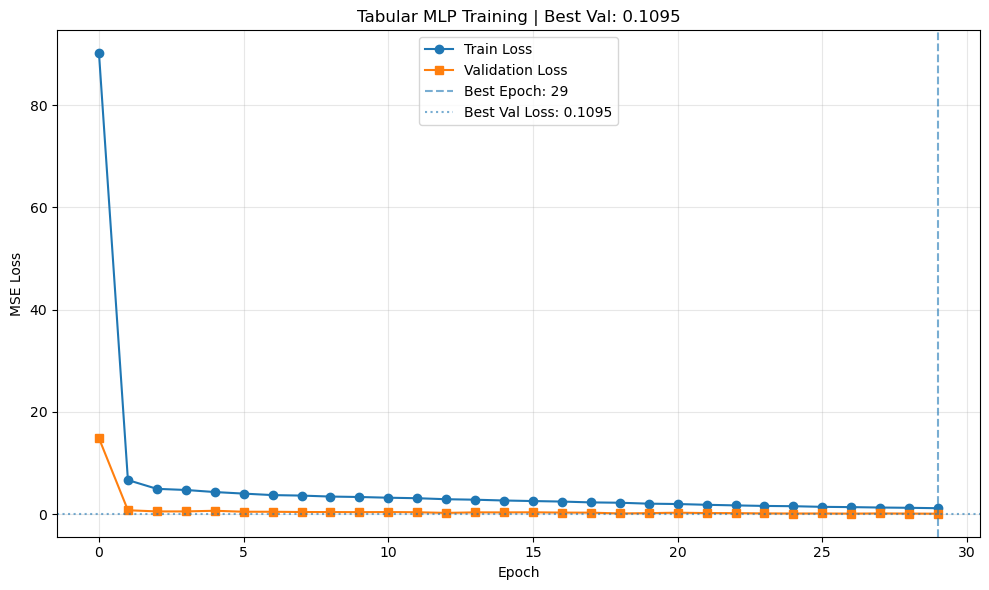

In [10]:
import matplotlib.pyplot as plt
import numpy as np

best_epoch = np.argmin(val_losses)
best_val_loss = val_losses[best_epoch]

plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')

plt.axvline(
    x=best_epoch,
    linestyle='--',
    alpha=0.6,
    label=f'Best Epoch: {best_epoch}'
)

plt.axhline(
    y=best_val_loss,
    linestyle=':',
    alpha=0.6,
    label=f'Best Val Loss: {best_val_loss:.4f}'
)

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'Tabular MLP Training | Best Val: {best_val_loss:.4f}')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tabular_mlp_training_curve.png', dpi=300)
plt.show()


In [11]:
model.eval()
preds = []

with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        preds.extend(model(x).cpu().numpy().flatten())

preds_dollars = np.expm1(preds)

submission = pd.DataFrame({
    'property_id': range(len(preds_dollars)),
    'predicted_price': preds_dollars
})

submission.to_csv('mlp_tabular_predictions.csv', index=False)

print("✅ Predictions saved")
print("Sample predictions:", preds_dollars[:5])


✅ Predictions saved
Sample predictions: [ 409109.88  498857.2  1157066.2  2552666.2   501732.28]
